In [13]:
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords
# nltk.download()

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_columns', None)

In [14]:
wine = pd.read_csv('redwine.csv', delimiter=';')
chemColNames = ['fixed acidity','volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol']
chem = wine[chemColNames]

colErrorPairs = {
    'density'    : [' . '],
    'citric acid': [' - ',' -   '],
    'alcohol'    : ['100.333.333.333.333','11.066.666.666.666.600','956.666.666.666.667','923.333.333.333.333']}

for colName in colErrorPairs:
    for faultyString in colErrorPairs[colName]:
        wine[colName] = wine[colName].replace(faultyString,np.nan)
        
wine['alcohol'] = wine['alcohol'].astype(float)
wine['density'] = wine['density'].astype(float)
wine['citric acid'] = wine['citric acid'].astype(float)

wineZscore = wine.copy()

for col in chemColNames:
        wineZscore[col] = (wine[col] - wine[col].mean())/wine[col].std(ddof=0)


# Onderzoeksvraag 1: In hoeverre is de score van een Portugese Red te voorspellen op basis van de chemische kenmerken?


## Lineaire regressie

Voor de eerste verplichte onderzoeksvraag gaan we supervised machine learning gebruiken. We willen de score van een wijn gaan voorspellen aan de hand van de chemische samenstelling. Dit gaan we doen met behulp van lineaire regressie. 

__1. Kies een modeltype__ 

In [15]:
from sklearn.linear_model import LinearRegression

__2. Kies de hyperparameters__


__3. Organiseer de data (feature matrix, target vector)__

Omdat we op basis van de chemische samenstelling willen gaan voorspellen, worden dit onze feature variabelen. 

In [16]:
chem.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,10.0,0.29,0.4,2.9,0.098,10.0,26.0,10.006,3.48,0.91,9.7
1,8.3,0.26,0.37,1.4,0.076,8.0,23.0,0.9974,3.26,0.70,9.6
2,7.0,0.69,0.07,2.5,0.091,15.0,21.0,0.99572,3.38,0.60,11.3
3,7.0,0.69,0.07,2.5,0.091,15.0,21.0,0.99572,3.38,0.60,11.3
4,8.0,0.48,0.34,2.2,0.073,16.0,25.0,0.9936,3.28,0.66,12.4


### Standaardiseren

Omdat de waardes van de features nogal uit elkaar liggen gaan we ze eerst standaardiseren met behulp van de Z Score. Zo zorgen we ervoor dat elke waarde tussen de -1 en 1 komt te liggen, zodat alle kolommen even zwaar mee tellen. 

In [17]:
features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates']

In [18]:
X = wineZscore[features]
X.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates
0,0.949660,-1.331760,0.542728,0.240020,0.223558,-0.559372,-0.639480,0.827622,1.096839,1.447261
1,-0.030452,-1.499514,0.380840,-0.826272,-0.244190,-0.752104,-0.729893,-0.126222,-0.332697,0.229843
2,-0.779950,0.904967,-1.238041,-0.044324,0.074729,-0.077542,-0.790169,-0.126400,0.447050,-0.349880
3,-0.779950,0.904967,-1.238041,-0.044324,0.074729,-0.077542,-0.790169,-0.126400,0.447050,-0.349880
4,-0.203413,-0.269315,0.218952,-0.257583,-0.307974,0.018824,-0.669618,-0.126624,-0.202740,-0.002046


De target variabele is bij deze onderzoeksvraag de points, dit is namelijk de variabele die we willen voorspellen. 

In [19]:
y = wine.points
y.head()

0    87
1    91
2    90
3    90
4    92
Name: points, dtype: int64

__4. Creeër een training- en validatie set.__

Nu gaan we een training en test set creëeren. Door het opvullen van lege waarden met de gemiddelden verhogen we linreg.score() een beetje, deze komt later aan bod. 

In [20]:
X.fillna(X.mean(),inplace=True)
y.fillna(y.mean(),inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

C:\Python383\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


De wijn dataset bestaat uit 2465 records, we gebruiken ongeveer 75% van de waardes voor de trainingset en de overige 25% voor de testset. 

In [21]:
len(wine)

2465

In [34]:
len(X_train)
(X_train.shape, y_train.shape)

((1848, 10), (1848,))

In [23]:
len(X_test)

617

In [24]:
linreg = LinearRegression()

Het model gaat nu leren aan de hand van de data uit de trainingsset. 

In [25]:
linreg.fit(X_train, y_train)

LinearRegression()

We gaan nu de kwaliteit van het model berekenen op basis van de data uit de testset. 

In [26]:
linreg.score(X_test,y_test)

0.17942720741894747

De score van het model is 0.04, dat deze score zo dicht bij 0 ligt wil eigenlijk zeggen dat er geen lineair verband te leggen is tussen de features en de target variabelen. 

In [27]:
y_pred = linreg.predict(X_test)

De mean squared error is de gemiddelde afwijking van de voorspelde waarden. Je wilt dit getal zo laag mogelijk hebben omdat het dus een error aangeeft. 

In [28]:
np.sqrt(mean_squared_error(y_test,y_pred))

2.7598026655957906

### Correlatie

Correlatie toont de samenhang tussen variabelen. Hiervoor gebruiken we wederom de Zscore. Bij een grote correlatie kun je aan de hand van de ene variabele heel goed de andere voorspellen, bij een kleine correlatie gaat dit (bijna) niet. 

Correlatie kan positief en negatief zijn. Positieve correlatie wil zeggen dat wanneer X toeneemt, Y ook toeneemt. Negatieve correlatie wil zeggen dat wanneer X toeneemt, Y afneemt. Omdat een correlatie tussen de -0.4 en 0.4 zo klein is, kun je eigenlijk niet echt spreken van samenhang. 

In [29]:
wineZscore.corr()

,id,points,price,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
id,1.000000,0.020210,-0.025849,-0.022630,-0.060455,-0.008533,0.004168,0.027883,-0.017302,-0.047292,-0.041125,-0.011499,0.028872,-0.026607
points,0.020210,1.000000,0.586486,0.090071,-0.341131,0.185946,-0.002561,-0.132438,-0.059912,-0.198235,-0.042680,-0.021553,0.205161,0.473751
price,-0.025849,0.586486,1.000000,0.031478,-0.182749,0.117633,0.009046,-0.088986,-0.035449,-0.117392,-0.037046,-0.003534,0.100095,0.351717
fixed acidity,-0.022630,0.090071,0.031478,1.000000,-0.251469,0.658574,0.122001,0.085792,-0.146259,-0.103413,0.259202,-0.683750,0.179621,-0.033511
volatile acidity,-0.060455,-0.341131,-0.182749,-0.251469,1.000000,-0.520726,-0.001796,0.057571,0.004527,0.090757,0.024151,0.235531,-0.249800,-0.202710
citric acid,-0.008533,0.185946,0.117633,0.658574,-0.520726,1.000000,0.115617,0.198535,-0.086514,-0.027528,0.081946,-0.498958,0.296286,0.164078
residual sugar,0.004168,-0.002561,0.009046,0.122001,-0.001796,0.115617,1.000000,0.032883,0.196488,0.201968,0.283973,-0.080360,0.005866,0.042495
chlorides,0.027883,-0.132438,-0.088986,0.085792,0.057571,0.198535,0.032883,1.000000,0.011536,0.059917,0.070043,-0.260800,0.373699,-0.214887
free sulfur dioxide,-0.017302,-0.059912,-0.035449,-0.146259,0.004527,-0.086514,0.196488,0.011536,1.000000,0.675317,0.095521,0.074212,0.057024,-0.083033
total sulfur dioxide,-0.047292,-0.198235,-0.117392,-0.103413,0.090757,-0.027528,0.201968,0.059917,0.675317,1.000000,0.045214,-0.070769,0.053834,-0.247554


__Correlatie tussen de variabelen__

We gaan kijken naar de samenhang tussen variabelen onderling. Zowel featurue variabelen met elkaar, als target en feature variabelen. Hieronder zien we welke combinatie van variabelen met meest correleren met elkaar.  

In [30]:
c = wineZscore.corr().abs()
s = c.unstack()
so = s.sort_values(kind="quicksort")
so[172:182]

citric acid           volatile acidity        0.520726
volatile acidity      citric acid             0.520726
price                 points                  0.586486
points                price                   0.586486
citric acid           fixed acidity           0.658574
fixed acidity         citric acid             0.658574
total sulfur dioxide  free sulfur dioxide     0.675317
free sulfur dioxide   total sulfur dioxide    0.675317
fixed acidity         pH                      0.683750
pH                    fixed acidity           0.683750
dtype: float64

Points en price zijn redelijk gecorreleert, dit kan interessant zijn maar helaas is price niet een feature variabelen. Voor deze onderzoeksvraag hebben we daar dus helaas niet heel veel aan. Wel zien we hier enigzins een positieve correlatie. 

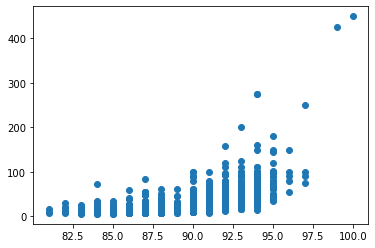

In [31]:
plt.scatter(wine.points, wine.price)

Verder zien we in de tabel hierboven nog dat fixed acidity en pH sterk gecorreleert zijn. Bij sterke correlatie tussen twee feature variabelen kun je gaan nadenken of dit wijst op redundantie, misschien heb je maar 1 van de twee variabelen nodig als ze toch bijna hetzelfde aangeven. Ook kunnen de twee variabelen juist elkaar tegen werken. 

In [32]:
fa = wine['fixed acidity']

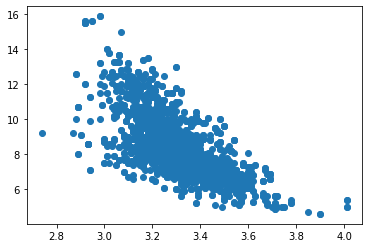

In [33]:
plt.scatter(wine.pH, fa)

#### Conclusie: tussen de feature en de target variabelen is weinig samenhang te vinden. Is het mogelijk om de score van de wijn te voorspellen aan de hand van de chemische samenstelling? Nee, eigenlijk niet. Misschien kunnen we beter de score van de wijn gaan voorspellen aan de hand van de prijs. 